# Load Data and Dependencies

In [1]:
!pip install imblearn
!pip install xgboost
!pip install session_info

  Using cached imblearn-0.0-py2.py3-none-any.whl.metadata (355 bytes)
  Using cached imbalanced_learn-0.12.0-py3-none-any.whl.metadata (8.2 kB)
Using cached imblearn-0.0-py2.py3-none-any.whl (1.9 kB)
Using cached imbalanced_learn-0.12.0-py3-none-any.whl (257 kB)
  Using cached xgboost-2.0.3-py3-none-manylinux2014_x86_64.whl.metadata (2.0 kB)
Using cached xgboost-2.0.3-py3-none-manylinux2014_x86_64.whl (297.1 MB)
  Using cached session_info-1.0.0-py3-none-any.whl
  Using cached stdlib_list-0.10.0-py3-none-any.whl.metadata (3.3 kB)
Using cached stdlib_list-0.10.0-py3-none-any.whl (79 kB)


In [43]:
# load dependencies
import session_info # for package versions etc.
import pandas as pd # for importing and handling data
import numpy as np # for working with arrays
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold, cross_validate # for splitting data and hyperparameter tuning
from sklearn.preprocessing import LabelEncoder # for processing data for xgboost
from imblearn.over_sampling import SMOTE # for smote oversampling
import xgboost as xgb # for xgboost model
from xgboost import plot_importance
from sklearn.metrics import confusion_matrix, f1_score, mean_squared_error, accuracy_score, mean_absolute_error, roc_curve, auc, roc_auc_score # for model performance metrics
import matplotlib.pyplot as plt # for ROC curve

In [3]:
session_info.show()

In [4]:
# load data
df = pd.read_csv("/home/jupyter/final_project/pisa_median.csv")
df.head()

,Unnamed: 0,ST352Q06JA,AGE,ST004D01T,DURECEC,REPEAT,MISSSC,SKIPPING,TARDYSD,EXPECEDU,...,ST353Q07JA,ST353Q08JA,ST348Q01JA,ST348Q02JA,ST348Q03JA,ST348Q04JA,ST348Q05JA,ST348Q06JA,ST348Q07JA,ST348Q08JA
0,1.0,2.0,15.58,1.0,2.0,0.0,0.0,1.0,2.0,7.0,...,2.0,2.0,4.0,4.0,4.0,3.0,4.0,3.0,2.0,2.0
1,2.0,2.0,16.17,2.0,2.0,0.0,1.0,0.0,1.0,7.0,...,4.0,4.0,2.0,3.0,2.0,3.0,4.0,4.0,4.0,4.0
2,3.0,4.0,15.58,2.0,0.0,0.0,0.0,0.0,0.0,9.0,...,2.0,3.0,3.0,3.0,2.0,3.0,3.0,2.0,2.0,2.0
3,4.0,4.0,15.42,2.0,2.0,0.0,0.0,0.0,0.0,4.0,...,1.0,2.0,1.0,3.0,4.0,1.0,4.0,1.0,2.0,1.0
4,5.0,2.0,15.75,2.0,1.0,0.0,0.0,0.0,0.0,8.0,...,2.0,2.0,1.0,3.0,4.0,3.0,4.0,3.0,2.0,2.0


# Split Data into Training and Test

In [5]:
# split into target and features
y = df["ST352Q06JA"].values
X = df.drop(["ST352Q06JA", "Unnamed: 0"], axis=1).values

In [6]:
# split data into training and test
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.2, # common to use 20-30% of data as test set
                                                    random_state = 2001, # set seed equivalent
                                                    stratify = y) # outcome amounts equal in train and test

In [10]:
print(X_train[0:3])
print(y_train[0:3])

[[ 1.5670e+01  2.0000e+00  2.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00
   0.0000e+00  8.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00
   6.0000e+00  1.0000e+01  0.0000e+00  6.0000e+00 -7.1900e-02 -1.2280e+00
   1.1246e+00  1.4750e-01 -7.1000e-03 -3.2030e-01  2.7474e+00 -9.7550e-01
   1.8227e+00  5.2030e-01  2.3650e+00  3.8830e+00  1.1187e+00  4.9584e+00
   1.3749e+00  2.4100e-02  1.3679e+00  3.1637e+00  1.7174e+00  1.7465e+00
   1.0481e+00  1.0000e+00  1.0000e+00  1.0000e+00  2.0000e+00  1.0000e+00
   2.0000e+00  1.0000e+00  3.0000e+00  3.0000e+00  4.0000e+00  3.0000e+00
   4.0000e+00  2.0000e+00  2.0000e+00  1.0000e+00  1.0000e+00  1.0000e+00
   2.0000e+00  2.0000e+00  2.0000e+00  2.0000e+00  3.0000e+00  3.0000e+00
   3.0000e+00  4.0000e+00  4.0000e+00  2.0000e+00  1.0000e+00]
 [ 1.5830e+01  1.0000e+00  4.0000e+00  0.0000e+00  0.0000e+00  1.0000e+00
   0.0000e+00  6.0000e+00  1.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00
   0.0000e+00  1.0000e+01  6.0000e+00  1.0000e+01

# Conduct Oversampling with SMOTE on Training Data

In [7]:
# frequency of observations in training data pre-oversampling
temp = y_train.astype(int)
np.bincount(temp)

array([   0, 1349, 2325, 2088, 3182])

In [8]:
# conduct oversampling on training data using SMOTE
# SMOTE overview here: https://www.youtube.com/watch?v=1Ic7GRtDrPM
smote = SMOTE(random_state = 2001)
X_smote, y_smote = smote.fit_resample(X_train, y_train)

In [9]:
# convert y_smote to integer (needed for xgboost later)
y_smote = y_smote.astype(int)
np.bincount(y_smote)

array([   0, 3182, 3182, 3182, 3182])

In [10]:
# transform data to work with xgboost (encoding needs to start at zero)
le = LabelEncoder()
y_smote = le.fit_transform(y_smote)

In [11]:
type(X_smote)
X_smote.shape

(12728, 65)

# Hyperparameter Tuning and Cross-Validation for xgboost

We want to train hyperparameters for `eta` (learning rate), `n_estimators` (number of estimators), and `colsample_bytree` (proportion of total features considered at each split). Specifically, using the following values:

* `eta`: 0.01, 0.05, 0.1, 0.3
* `n_estimators`: 100, 200, 500, 1000, 2000
* `colsample_bytree`: 0.1, 0.5, 0.7, 1.0

Furthermore, we will conduct 5-fold cross-validation for each training model to return an aggregate RMSE value. In total, that yields 4 (`eta`) x 5 (`n_estimators`) x 4 (`colsample_bytree`) x 5 (cross-validation) = 400 estimated models. We will use randomized search for this endeavour.

In [12]:
# create values for hyperparameter tuning
parameter_grid = {'learning_rate': [0.01, 0.05, 0.1, 0.3],
             'n_estimators': [100, 200, 500, 1000, 2000],
             'colsample_bytree': [0.1, 0.5, 0.7, 1.0]}

In [13]:
clf = xgb.XGBClassifier(random_state = 2001)

cross_val = KFold(5, random_state = 2001, shuffle=True)

In [ ]:
# clf_grid = GridSearchCV(estimator = clf,
#                                 param_grid = parameter_grid,
#                                 scoring = "neg_mean_squared_error",
#                                 cv = cross_val,
#                                 verbose = 1,
#                                 return_train_score = True)

In [23]:
# clf_grid.fit(X_smote, y_smote)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=2001, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     i...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=2001, ...),
             param_grid={'colsample_bytree': [0.1, 0.5, 0.7, 1.0],
                         'learning_rate': [0.01, 0.05, 0.1, 0.3],
                         'n_estimators': [100, 200, 500, 1000, 2000]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=1)

In [24]:
# clf_grid.cv_results_
# print(clf_grid.best_score_)
# print(clf_grid.best_params_)
# print(clf_grid.best_index_)
# clf_grid.cv_results_['params'][clf_grid.best_index_]

-0.7029368306847521
{'colsample_bytree': 0.5, 'learning_rate': 0.1, 'n_estimators': 1000}
33


{'colsample_bytree': 0.5, 'learning_rate': 0.1, 'n_estimators': 1000}

In [25]:
# # convert results to pandas df
# cv_results_dict = pd.DataFrame.from_dict(clf_grid.cv_results_)

# # write to csv for future reference
# cv_results_dict.to_csv("/home/jupyter/final_project/xgb_cv_results.csv")

# cv_results_dict

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_learning_rate,param_n_estimators,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,1.768965,0.035886,0.040885,0.020003,0.1,0.01,100,"{'colsample_bytree': 0.1, 'learning_rate': 0.0...",-1.071877,-0.985860,...,-1.013591,0.034698,80,-0.827735,-0.794245,-0.789039,-0.811254,-0.803201,-0.805095,0.013635
1,3.480168,0.082015,0.058982,0.000561,0.1,0.01,200,"{'colsample_bytree': 0.1, 'learning_rate': 0.0...",-1.023566,-0.981540,...,-1.004322,0.030071,79,-0.776763,-0.739442,-0.746022,-0.747029,-0.749190,-0.751689,0.012952
2,8.484597,0.076963,0.174741,0.041907,0.1,0.01,500,"{'colsample_bytree': 0.1, 'learning_rate': 0.0...",-0.912019,-0.889631,...,-0.909728,0.021197,76,-0.616185,-0.605775,-0.600275,-0.598056,-0.605814,-0.605221,0.006272
3,16.870224,0.259230,0.355146,0.019923,0.1,0.01,1000,"{'colsample_bytree': 0.1, 'learning_rate': 0.0...",-0.846819,-0.835428,...,-0.848368,0.018492,68,-0.424475,-0.403261,-0.421528,-0.411667,-0.418737,-0.415933,0.007628
4,33.750319,1.261094,0.746841,0.024281,0.1,0.01,2000,"{'colsample_bytree': 0.1, 'learning_rate': 0.0...",-0.791830,-0.813040,...,-0.803740,0.016039,58,-0.186309,-0.170595,-0.175800,-0.170677,-0.181970,-0.177070,0.006225
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,4.400641,0.063208,0.041248,0.014610,1.0,0.3,100,"{'colsample_bytree': 1.0, 'learning_rate': 0.3...",-0.687353,-0.763158,...,-0.757388,0.036248,36,-0.013455,-0.008839,-0.013062,-0.008838,-0.015516,-0.011942,0.002668
76,8.081089,0.169628,0.062616,0.007492,1.0,0.3,200,"{'colsample_bytree': 1.0, 'learning_rate': 0.3...",-0.684996,-0.727808,...,-0.729261,0.028217,21,-0.000000,-0.000000,-0.000000,-0.000000,-0.000393,-0.000079,0.000157
77,16.640020,0.201813,0.148675,0.001219,1.0,0.3,500,"{'colsample_bytree': 1.0, 'learning_rate': 0.3...",-0.669285,-0.705420,...,-0.720698,0.030012,11,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000
78,27.887004,0.362617,0.318817,0.004580,1.0,0.3,1000,"{'colsample_bytree': 1.0, 'learning_rate': 0.3...",-0.664179,-0.721917,...,-0.719675,0.029154,9,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000


# Visualizing and Pulling Hyperparameters

In [14]:
# read csv of results (so you don't have to run hyperparameter tuning again)
hyperparams = pd.read_csv("xgb_cv_results.csv")

# get best hyperparameters
print(hyperparams[hyperparams["rank_test_score"] == 1])
eta = hyperparams[hyperparams["rank_test_score"] == 1]["param_learning_rate"].values[0]
n_estimators =  hyperparams[hyperparams["rank_test_score"] == 1]["param_n_estimators"].values[0]
colsample_bytree = hyperparams[hyperparams["rank_test_score"] == 1]["param_colsample_bytree"].values[0]

    Unnamed: 0  mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
33          33      24.466784      0.326777         0.319741        0.020982   

    param_colsample_bytree  param_learning_rate  param_n_estimators  \
33                     0.5                  0.1                1000   

                                               params  split0_test_score  ...  \
33  {'colsample_bytree': 0.5, 'learning_rate': 0.1...          -0.689317  ...   

    mean_test_score  std_test_score  rank_test_score  split0_train_score  \
33        -0.702937        0.017051                1                -0.0   

    split1_train_score  split2_train_score  split3_train_score  \
33                -0.0                -0.0                -0.0   

    split4_train_score  mean_train_score  std_train_score  
33                -0.0               0.0              0.0  

[1 rows x 24 columns]


In [15]:
print(eta, n_estimators, colsample_bytree)

0.1 1000 0.5


In [ ]:
# graph rmse by each hyperparameter to visualize 

# could even use plotly for a 3D plot

# Training Model Performance

In [16]:
# fit cross_val with best estimator in training data to get various outcomes beyond rmse
# instantiate classifier
clf = xgb.XGBClassifier(n_estimators = n_estimators,
                        learning_rate = eta,
                        colsample_bytree = colsample_bytree,
                        random_state = 2001)

In [17]:
# fit classifier to training data
clf.fit(X_smote, y_smote)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [18]:
# fit cross_val to test data, get predicted values
# cross_val KFold object created earlier
# could replace this with cross_validation to get multiple scores at once
# train_scores = cross_val_score(clf, X_smote, y_smote, cv=cross_val)
train_scores = cross_validate(clf,
                              X_smote,
                              y_smote,
                              cv = cross_val,
                              scoring = ["neg_mean_squared_error", "f1_micro", "neg_root_mean_squared_error", "neg_mean_absolute_error", "roc_auc_ovr"],
                              return_train_score = True)

In [19]:
train_scores

{'fit_time': array([26.51184845, 26.28641582, 26.51850057, 27.40339112, 27.21596456]),
 'score_time': array([0.7627697 , 0.7625823 , 0.75036883, 0.75933886, 0.79728889]),
 'test_neg_mean_squared_error': array([-0.68931658, -0.70895522, -0.73055774, -0.70451866, -0.68133595]),
 'train_neg_mean_squared_error': array([-0., -0., -0., -0., -0.]),
 'test_f1_micro': array([0.71052632, 0.69520817, 0.69520817, 0.71198428, 0.70294695]),
 'train_f1_micro': array([1., 1., 1., 1., 1.]),
 'test_neg_root_mean_squared_error': array([-0.83025091, -0.84199479, -0.8547267 , -0.8393561 , -0.82543077]),
 'train_neg_root_mean_squared_error': array([-0., -0., -0., -0., -0.]),
 'test_neg_mean_absolute_error': array([-0.40966222, -0.42458759, -0.43047918, -0.40903733, -0.41178782]),
 'train_neg_mean_absolute_error': array([-0., -0., -0., -0., -0.]),
 'test_roc_auc_ovr': array([0.90390871, 0.89002634, 0.90138447, 0.89996428, 0.89802343]),
 'train_roc_auc_ovr': array([1., 1., 1., 1., 1.])}

In [26]:
# f1 score
print(f"Training F1 score: {(train_scores['train_f1_micro']).mean()}")
print(f"Validation F1 score: {(train_scores['test_f1_micro']).mean()}")
print(f"Validation F1 SD: {(train_scores['test_f1_micro']).std()}\n")

# mean squared error
print(f"Training MSE score: {(-1*train_scores['train_neg_mean_squared_error']).mean()}")
print(f"Validation MSE score: {(-1*train_scores['test_neg_mean_squared_error']).mean()}")
print(f"Validation MSE SD: {(-1*train_scores['test_neg_mean_squared_error']).std()}\n")

# root mean squared error
print(f"Training RMSE score: {np.sqrt(-1*train_scores['train_neg_mean_squared_error']).mean()}")
print(f"Validation RMSE score: {np.sqrt(-1*train_scores['test_neg_mean_squared_error']).mean()}")
print(f"Validation RMSE SD: {np.sqrt(-1*train_scores['test_neg_mean_squared_error']).std()}\n")

# mean absolute error
print(f"Training MAE score: {(-1*train_scores['train_neg_mean_absolute_error']).mean()}")
print(f"Validation MAE score: {(-1*train_scores['test_neg_mean_absolute_error']).mean()}")
print(f"Validation MAE score: {(-1*train_scores['test_neg_mean_absolute_error']).std()}\n")

# ROC
print(f"Training ROC score: {(train_scores['train_roc_auc_ovr']).mean()}")
print(f"Validation ROC score: {(train_scores['test_roc_auc_ovr']).mean()}")
print(f"Validation ROC score: {(train_scores['test_roc_auc_ovr']).std()}\n")

Training F1 score: 1.0
Validation F1 score: 0.7031747785732696
Validation F1 SD: 0.007192191381035728

Training MSE score: 0.0
Validation MSE score: 0.7029368306847521
Validation MSE SD: 0.017051375554274762

Training RMSE score: 0.0
Validation RMSE score: 0.838351854355136
Validation RMSE SD: 0.010148841513042262

Training MAE score: 0.0
Validation MAE score: 0.4171108267986918
Validation MAE score: 0.008759138277866688

Training ROC score: 1.0
Validation ROC score: 0.8986614480829775
Validation ROC score: 0.004724787385837059



In [47]:
# get order of feature importances, sorted from least to most important
sorted_idx = clf.feature_importances_.argsort() 
sorted_idx

array([ 0, 29, 22, 25, 32, 18, 30, 27, 15, 28, 35, 26, 16, 60, 36, 57,  2,
       12, 17, 23, 24,  7, 31, 19, 10, 14, 34, 20,  8, 46, 11,  6,  4, 47,
       54,  5, 33, 21, 58, 51, 49, 52, 59, 62,  9, 13, 61, 45, 53, 64, 44,
       50, 55, 63,  3, 56,  1, 37, 39, 48, 38, 40, 41, 43, 42])

In [48]:
# get best 15 indices, i.e. the last 15
top_15_idx = sorted_idx[-15:]
top_15_idx

array([44, 50, 55, 63,  3, 56,  1, 37, 39, 48, 38, 40, 41, 43, 42])

In [50]:
# get corresponding feature names
top_features = np.array(df.drop(["ST352Q06JA", "Unnamed: 0"], axis=1).columns)[top_15_idx]
top_features

array(['ST354Q02JA', 'ST353Q02JA', 'ST353Q07JA', 'ST348Q07JA', 'REPEAT',
       'ST353Q08JA', 'ST004D01T', 'ST352Q01JA', 'ST352Q03JA',
       'ST354Q09JA', 'ST352Q02JA', 'ST352Q04JA', 'ST352Q05JA',
       'ST352Q08JA', 'ST352Q07JA'], dtype=object)

In [51]:
# get corresponding feature importances
top_importances = clf.feature_importances_[top_15_idx]
top_importances

array([0.01413068, 0.01426246, 0.01439411, 0.01466959, 0.01531592,
       0.01621133, 0.01680167, 0.0183844 , 0.01999118, 0.0259435 ,
       0.03559916, 0.03697712, 0.04105233, 0.07940711, 0.13726397],
      dtype=float32)

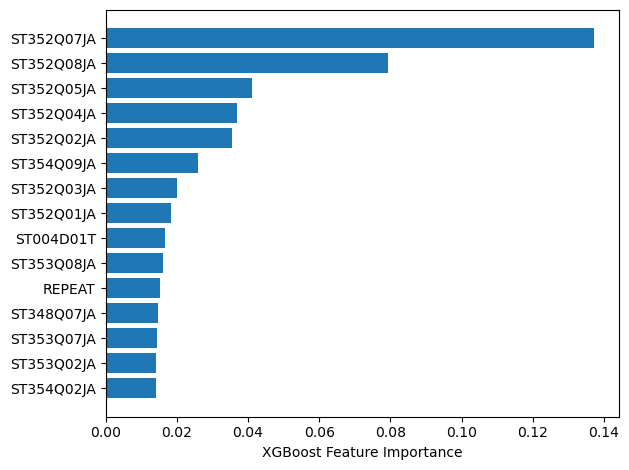

In [55]:
# plot top 15 features
plt.barh(top_features, top_importances)
plt.xlabel("XGBoost Feature Importance")
# export to png
plt.tight_layout() # prevent label cropping
plt.savefig('top_features_xgb.png', dpi=300)
plt.show()

# Test Model Performance

In [23]:
# compare predicted values to actual y_test
y_pred = clf.predict(X_test)
# reverse transformation xgboost required
y_pred = le.inverse_transform(y_pred)
# could do in one line, but it's harder to read: le.inverse_transform(clf.predict(X_test))

# get outcomes of interest
# confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

# ROC curve
roc = roc_auc_score(y_test,
                    clf.predict_proba(X_test),
                    multi_class="ovr",
                    average="macro")
print(f'ROC score: {round(roc, 3)}')

# F1 score
f1 = f1_score(y_test, y_pred, average="micro")
print(f'f1 score: {round(f1, 3)}')

# Mean Squared error
mse = mean_squared_error(y_test, y_pred)
print(f'mean squared error: {round(mse, 3)}')

# Root mean squared error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'root mean squared error: {round(rmse, 3)}')

# Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred)
print(f'mean absolute error: {round(mae, 3)}')

[[182  86  24  45]
 [ 67 312  93 110]
 [ 22 139 189 172]
 [ 41  87  96 572]]
ROC score: 0.798
f1 score: 0.561
mean squared error: 1.072
root mean squared error: 1.036
mean absolute error: 0.624
